# Khai báo Thư Viện

In [ ]:
import os, sys, shutil, random
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from skimage.feature import hog, local_binary_pattern
from skimage import exposure

# Thư viện Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Tải tập dữ liệu

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dimensi0n/afhq-512")

print("Path to dataset files:", path)

100%|██████████| 6.48G/6.48G [01:12<00:00, 96.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dimensi0n/afhq-512/versions/1


In [ ]:
# Thư mục gốc chứa cat/dog/wild
base_dir = os.path.join(path)
print("Base dir (dataset gốc):", base_dir)

# Thư mục lưu sau khi chia train/val/test
output_dir = "/content/gdrive/MyDrive/afhq_split"
os.makedirs(output_dir, exist_ok=True)


Base dir (dataset gốc): /root/.cache/kagglehub/datasets/dimensi0n/afhq-512/versions/1


# EDA Dataset

In [ ]:
classes = sorted([d for d in os.listdir(base_dir)
                 if os.path.isdir(os.path.join(base_dir, d))])
print(f"Các lớp: {classes}")

Các lớp: ['cat', 'dog', 'wild']


In [ ]:
counts = []
for cname in classes:
    cpath = os.path.join(base_dir, cname)
    # Đếm số file ảnh
    num = len([f for f in os.listdir(cpath) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    counts.append((cname, num))

counts_df = pd.DataFrame(counts, columns=["Class","Count"])
display(counts_df)

,Class,Count
0,cat,5558
1,dog,5169
2,wild,5076


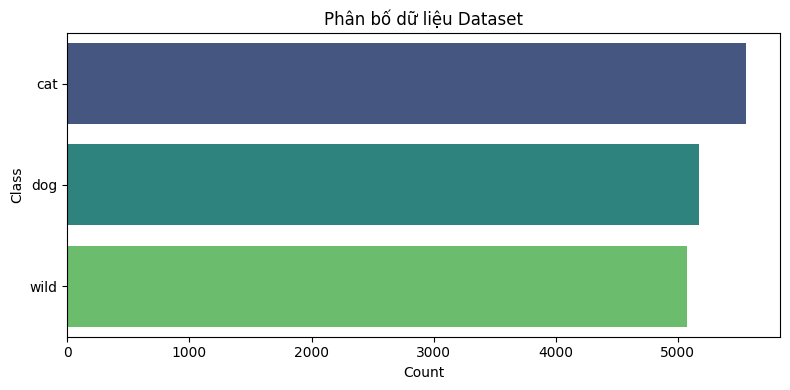

In [ ]:
counts_df = pd.DataFrame(counts, columns=["Class", "Count"])
plt.figure(figsize=(8, 4))
sns.barplot(data=counts_df, y="Class", x="Count", hue="Class", legend=False, palette="viridis")
plt.title("Phân bố dữ liệu Dataset")
plt.tight_layout()
plt.show()

# Hiển thị mỗi lớp một ảnh

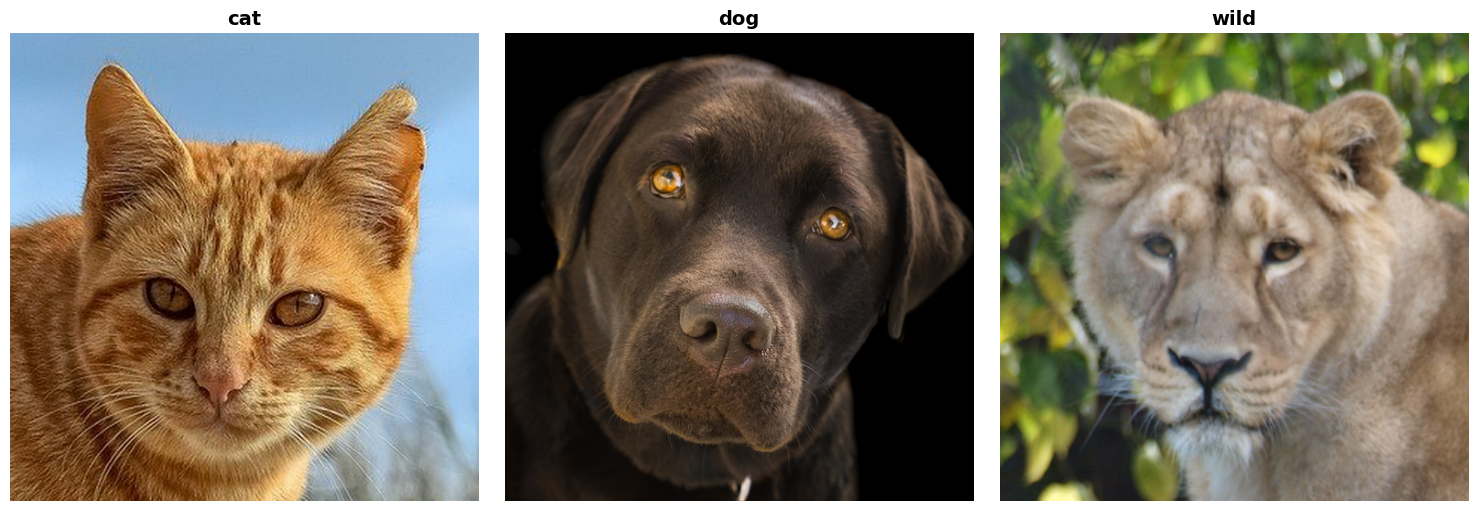

In [ ]:
from PIL import Image

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, cls in enumerate(classes):
    cls_path = os.path.join(base_dir, cls)
    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png'))]
    if imgs:
        img = Image.open(os.path.join(cls_path, imgs[0])).convert('RGB')
        axes[i].imshow(img)
        axes[i].set_title(cls, fontsize=14, fontweight='bold')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

# Chia tập dữ liệu

In [ ]:
TRAIN_DIR = f"{output_dir}/train"
TEST_DIR = f"{output_dir}/test"

In [ ]:
if os.path.exists(TRAIN_DIR) and os.path.exists(TEST_DIR):
    print("Dataset đã được chia trước đó. Skip.")
else:
    print("Đang chia dataset...")
    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        files = [os.path.join(cls_path, f) for f in os.listdir(cls_path)
                if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        train_files, test_files = train_test_split(files, test_size=0.2,
                                                   random_state=42)

        # Copy vào thư mục train
        train_cls_dir = os.path.join(TRAIN_DIR, cls)
        os.makedirs(train_cls_dir, exist_ok=True)
        for f in train_files:
            shutil.copy(f, train_cls_dir)

        # Copy vào thư mục test
        test_cls_dir = os.path.join(TEST_DIR, cls)
        os.makedirs(test_cls_dir, exist_ok=True)
        for f in test_files:
            shutil.copy(f, test_cls_dir)

        print(f"  {cls}: Train={len(train_files)}, Test={len(test_files)}")

Đang chia dataset...
  cat: Train=4446, Test=1112
  dog: Train=4135, Test=1034
  wild: Train=4060, Test=1016


# Minh họa mẫu

In [ ]:
sample_cls = classes[0]
class_dir = os.path.join(TRAIN_DIR, sample_cls)
image_list = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png'))]

# Chọn ảnh đầu tiên trong danh sách
sample_path = os.path.join(class_dir, image_list[0])
print(f"Đang minh họa đặc trưng HOG trên ảnh: {sample_path}")

Đang minh họa đặc trưng HOG trên ảnh: /content/gdrive/MyDrive/afhq_split/train/cat/3453.png


In [ ]:
def illustrate_hog(image_path):
    # 1. Đọc và tiền xử lý
    img = cv2.imread(image_path)
    if img is None: return
    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Tính toán HOG (Dùng cell 8x8 để vẽ cho đẹp và chi tiết)
    fd, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=None)

    # Tăng tương phản để dễ nhìn
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # 3. Vẽ hình
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(gray, cmap='gray')
    ax1.set_title("Ảnh gốc (Xám)")
    ax1.axis('off')

    ax2.imshow(hog_image_rescaled, cmap='gray')
    ax2.set_title("HOG: Đặc trưng Hình dáng\n(Biên dạng khuôn mặt)")
    ax2.axis('off')
    plt.show()

# Trích xuất đặc trưng

In [ ]:
def extract_hog_features_only(image_paths, target_size=(128, 128)):
    data_features = []

    hog_args = {
        'orientations': 9,
        'pixels_per_cell': (16, 16),
        'cells_per_block': (2, 2),
        'block_norm': 'L2-Hys',
        'feature_vector': True
    }

    print(f"[HOG] Đang trích xuất cho {len(image_paths)} ảnh...")

    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            print(f"Lỗi ảnh: {path}")
            continue

        img = cv2.resize(img, target_size)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        hog_feat = hog(gray, **hog_args)

        data_features.append(hog_feat)

    return np.array(data_features)

In [ ]:
def load_data(root_dir):
    image_paths = []
    labels = []
    classes = sorted(os.listdir(root_dir))
    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg', '.png')):
                image_paths.append(os.path.join(cls_dir, fname))
                labels.append(cls)
    return image_paths, labels

In [ ]:
print("Loading file paths...")
train_paths, y_train_labels = load_data(TRAIN_DIR)
test_paths, y_test_labels = load_data(TEST_DIR)

Loading file paths...


In [ ]:
# Encode nhãn (cat -> 0, dog -> 1...)
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

In [ ]:
X_train_hog = extract_hog_features_only(train_paths)
X_test_hog = extract_hog_features_only(test_paths)
print(f"Kích thước HOG Train: {X_train_hog.shape}")

[HOG] Đang trích xuất cho 12641 ảnh...
[HOG] Đang trích xuất cho 3162 ảnh...
Kích thước HOG Train: (12641, 1764)


# TRAIN MODEL

## RANDOM FOREST

Cấu hình tham số: {'n_estimators': [500], 'max_depth': [20], 'min_samples_leaf': [1]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best RF Params: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 500}
Best RF CV Accuracy: 0.9063

--- Đánh giá Random Forest trên tập Test ---
              precision    recall  f1-score   support

         cat       0.91      0.95      0.93      1112
         dog       0.88      0.90      0.89      1034
        wild       0.91      0.84      0.87      1016

    accuracy                           0.90      3162
   macro avg       0.90      0.90      0.90      3162
weighted avg       0.90      0.90      0.90      3162



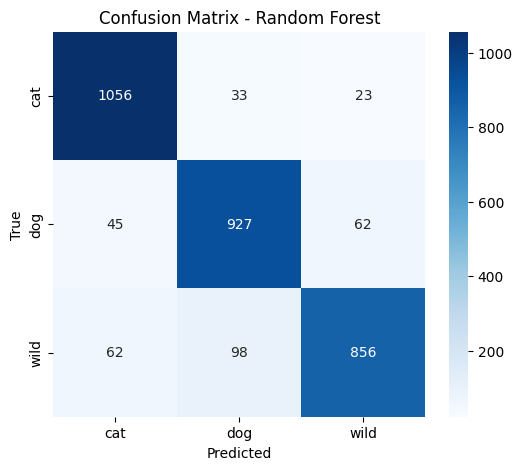

In [ ]:

rf = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)


param_grid_rf = {
    "n_estimators": [500],
    "max_depth": [20],
    "min_samples_leaf": [1]
}

print(f"Cấu hình tham số: {param_grid_rf}")
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rf.fit(X_train_hog, y_train)

print(f"Best RF Params: {grid_rf.best_params_}")
print(f"Best RF CV Accuracy: {grid_rf.best_score_:.4f}")

best_rf = grid_rf.best_estimator_

# Đánh giá trên tập Test
print("\n--- Đánh giá Random Forest trên tập Test ---")
y_pred_rf = best_rf.predict(X_test_hog)

print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Vẽ Confusion Matrix cho RF
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## SVM

Cấu hình tham số SVM: {'svm__C': [10], 'svm__gamma': [0.0001], 'svm__kernel': ['rbf']}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best SVM Params: {'svm__C': 10, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}
Best SVM CV Accuracy: 0.9316

--- Đánh giá SVM trên tập Test ---
              precision    recall  f1-score   support

         cat       0.96      0.96      0.96      1112
         dog       0.92      0.93      0.93      1034
        wild       0.93      0.92      0.92      1016

    accuracy                           0.94      3162
   macro avg       0.94      0.94      0.94      3162
weighted avg       0.94      0.94      0.94      3162



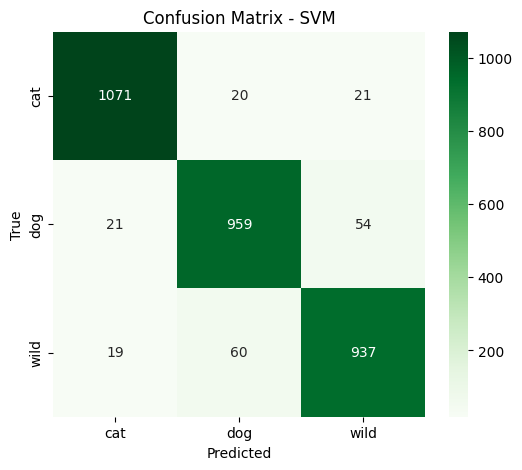

In [ ]:

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42, class_weight='balanced'))
])

param_grid_svm = {
    "svm__C": [10],
    "svm__gamma": [1e-4],
    "svm__kernel": ["rbf"]
}

# Grid Search
print(f"Cấu hình tham số SVM: {param_grid_svm}")
grid_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_svm.fit(X_train_hog, y_train)

best_svm = grid_svm.best_estimator_
print(f"Best SVM Params: {grid_svm.best_params_}")
print(f"Best SVM CV Accuracy: {grid_svm.best_score_:.4f}")

# Đánh giá trên tập Test
print("\n--- Đánh giá SVM trên tập Test ---")
y_pred_svm = best_svm.predict(X_test_hog)

print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

# Vẽ Confusion Matrix cho SVM
plt.figure(figsize=(6, 5))
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# So sánh hai mô hình

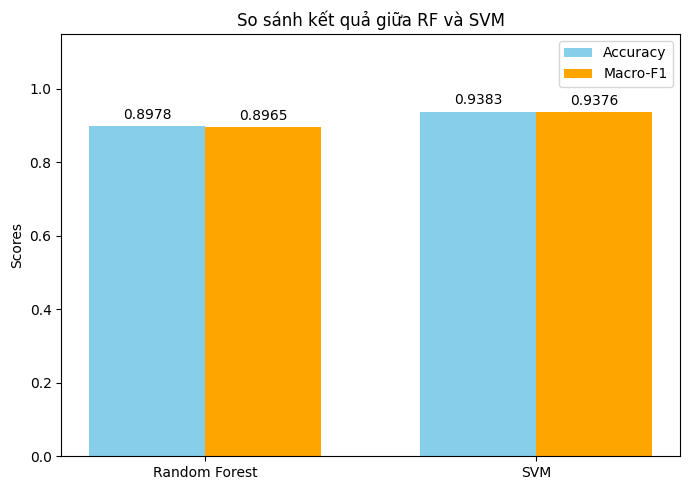

In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='macro')
svm_acc = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='macro')

models = ["Random Forest", "SVM"]
accs = [rf_acc, svm_acc]
f1s  = [rf_f1, svm_f1]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(7,5))

rects1 = ax.bar(x - width/2, accs, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, f1s,  width, label='Macro-F1', color='orange')

ax.set_ylabel('Scores')
ax.set_title('So sánh kết quả giữa RF và SVM')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 1.15)
plt.tight_layout()
plt.show()

# Task
So sánh và phân tích kết quả dự đoán của mô hình Random Forest và SVM trên tập kiểm tra, bao gồm:
1. Xác định số lượng ảnh được phân loại đúng bởi cả hai mô hình.
2. Xác định số lượng ảnh được phân loại sai bởi cả hai mô hình.
3. Xác định số lượng ảnh được Random Forest phân loại đúng nhưng SVM phân loại sai.
4. Xác định số lượng ảnh được SVM phân loại đúng nhưng Random Forest phân loại sai.
5. Tổng hợp và hiển thị các thống kê trên.

## So sánh dự đoán của hai mô hình

### Subtask:
So sánh dự đoán của mô hình Random Forest và SVM với nhãn thực tế trên tập kiểm tra (y_test) để xác định các trường hợp: đúng ở cả hai, sai ở cả hai, đúng ở RF và sai ở SVM, sai ở RF và đúng ở SVM.


**Reasoning**:
To compare the predictions of both models with the true labels, I will create boolean arrays for correct predictions for each model and then use logical operations to identify the indices for the four desired scenarios: both correct, both incorrect, RF correct/SVM incorrect, and SVM correct/RF incorrect. This directly addresses instructions 1-6.



In [ ]:
import numpy as np

# 1. Mảng boolean cho biết khi nào dự đoán của Random Forest khớp với nhãn thực tế
rf_correct = (y_pred_rf == y_test)

# 2. Mảng boolean cho biết khi nào dự đoán của SVM khớp với nhãn thực tế
svm_correct = (y_pred_svm == y_test)

# 3. Chỉ mục mà cả hai mô hình đều dự đoán đúng
both_correct_indices = np.where(rf_correct & svm_correct)[0]
print(f"Cả hai mô hình dự đoán đúng: {len(both_correct_indices)} trường hợp")

# 4. Chỉ mục mà cả hai mô hình đều dự đoán sai
both_incorrect_indices = np.where(~rf_correct & ~svm_correct)[0]
print(f"Cả hai mô hình dự đoán sai: {len(both_incorrect_indices)} trường hợp")

# 5. Chỉ mục mà Random Forest dự đoán đúng và SVM dự đoán sai
rf_correct_svm_incorrect_indices = np.where(rf_correct & ~svm_correct)[0]
print(f"RF đúng, SVM sai: {len(rf_correct_svm_incorrect_indices)} trường hợp")

# 6. Chỉ mục mà SVM dự đoán đúng và Random Forest dự đoán sai
svm_correct_rf_incorrect_indices = np.where(svm_correct & ~rf_correct)[0]
print(f"SVM đúng, RF sai: {len(svm_correct_rf_incorrect_indices)} trường hợp")

Cả hai mô hình dự đoán đúng: 2775 trường hợp
Cả hai mô hình dự đoán sai: 131 trường hợp
RF đúng, SVM sai: 64 trường hợp
SVM đúng, RF sai: 192 trường hợp


## Phân tích và minh họa các trường hợp khác biệt

### Subtask:
Tùy chọn hiển thị một vài ví dụ ảnh cho từng loại trường hợp (RF đúng/SVM sai, SVM đúng/RF sai, cả hai đều sai) để minh họa sự khác biệt trong hiệu suất dự đoán giữa hai mô hình.


**Reasoning**:
I need to display example images for the 'RF correct/SVM incorrect' scenario. First, I'll select a random index from `rf_correct_svm_incorrect_indices`, then retrieve the image path, true label, and both model predictions, and finally display this information along with the image.




--- RF correct, SVM incorrect ---
Ảnh: /content/gdrive/MyDrive/afhq_split/test/dog/1670.png
Nhãn thực tế: dog
RF dự đoán: dog (ĐÚNG)
SVM dự đoán: wild (SAI)


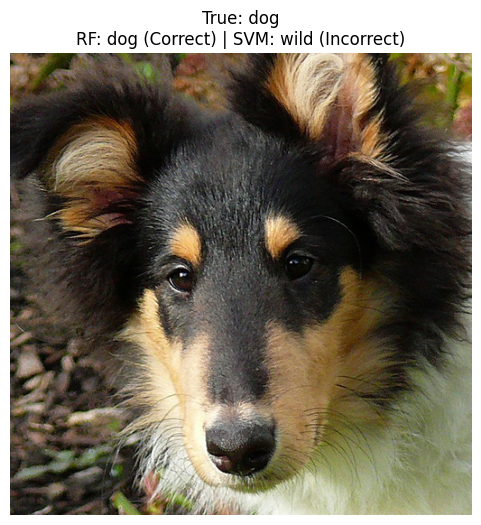

In [ ]:
import random
from PIL import Image

# --- Case 1: RF correct, SVM incorrect ---
print("\n--- RF correct, SVM incorrect ---")
if len(rf_correct_svm_incorrect_indices) > 0:
    idx = random.choice(rf_correct_svm_incorrect_indices)
    img_path = test_paths[idx]

    # Lấy tên lớp thay vì số
    true_label = le.classes_[y_test[idx]]
    rf_pred = le.classes_[y_pred_rf[idx]]
    svm_pred = le.classes_[y_pred_svm[idx]]

    print(f"Ảnh: {img_path}")
    print(f"Nhãn thực tế: {true_label}")
    print(f"RF dự đoán: {rf_pred} (ĐÚNG)")
    print(f"SVM dự đoán: {svm_pred} (SAI)")

    plt.figure(figsize=(6, 6))
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nRF: {rf_pred} (Correct) | SVM: {svm_pred} (Incorrect)")
    plt.axis('off')
    plt.show()
else:
    print("Không có trường hợp RF đúng, SVM sai để hiển thị.")

**Reasoning**:
I need to display example images for the 'SVM correct/RF incorrect' scenario. I will select a random index from `svm_correct_rf_incorrect_indices`, then retrieve the image path, true label, and both model predictions, and finally display this information along with the image.




--- SVM correct, RF incorrect ---
Ảnh: /content/gdrive/MyDrive/afhq_split/test/cat/5175.png
Nhãn thực tế: cat
RF dự đoán: wild (SAI)
SVM dự đoán: cat (ĐÚNG)


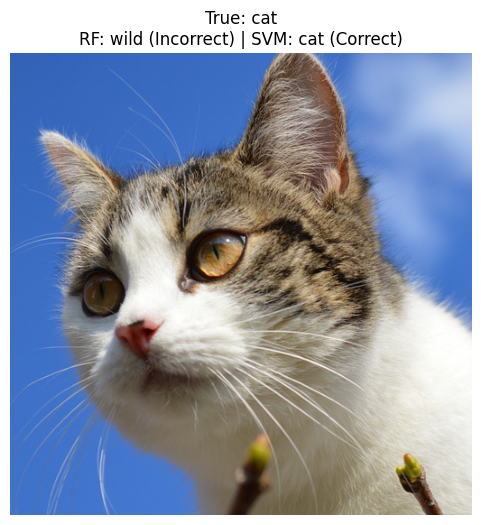

In [ ]:
# --- Case 2: SVM correct, RF incorrect ---
print("\n--- SVM correct, RF incorrect ---")
if len(svm_correct_rf_incorrect_indices) > 0:
    idx = random.choice(svm_correct_rf_incorrect_indices)
    img_path = test_paths[idx]

    # Lấy tên lớp thay vì số
    true_label = le.classes_[y_test[idx]]
    rf_pred = le.classes_[y_pred_rf[idx]]
    svm_pred = le.classes_[y_pred_svm[idx]]

    print(f"Ảnh: {img_path}")
    print(f"Nhãn thực tế: {true_label}")
    print(f"RF dự đoán: {rf_pred} (SAI)")
    print(f"SVM dự đoán: {svm_pred} (ĐÚNG)")

    plt.figure(figsize=(6, 6))
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nRF: {rf_pred} (Incorrect) | SVM: {svm_pred} (Correct)")
    plt.axis('off')
    plt.show()
else:
    print("Không có trường hợp SVM đúng, RF sai để hiển thị.")

**Reasoning**:
I need to display example images for the 'both incorrect' scenario. I will select a random index from `both_incorrect_indices`, then retrieve the image path, true label, and both model predictions, and finally display this information along with the image.




--- Cả hai mô hình đều dự đoán sai ---
Ảnh: /content/gdrive/MyDrive/afhq_split/test/wild/4402.png
Nhãn thực tế: wild
RF dự đoán: cat (SAI)
SVM dự đoán: dog (SAI)


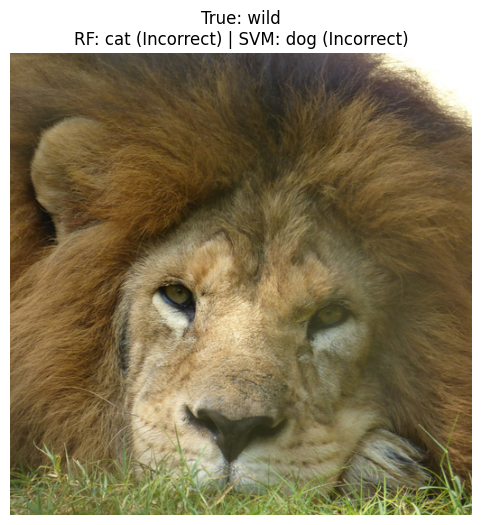

In [ ]:
# --- Case 3: Both incorrect ---
print("\n--- Cả hai mô hình đều dự đoán sai ---")
if len(both_incorrect_indices) > 0:
    idx = random.choice(both_incorrect_indices)
    img_path = test_paths[idx]

    # Lấy tên lớp thay vì số
    true_label = le.classes_[y_test[idx]]
    rf_pred = le.classes_[y_pred_rf[idx]]
    svm_pred = le.classes_[y_pred_svm[idx]]

    print(f"Ảnh: {img_path}")
    print(f"Nhãn thực tế: {true_label}")
    print(f"RF dự đoán: {rf_pred} (SAI)")
    print(f"SVM dự đoán: {svm_pred} (SAI)")

    plt.figure(figsize=(6, 6))
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nRF: {rf_pred} (Incorrect) | SVM: {svm_pred} (Incorrect)")
    plt.axis('off')
    plt.show()
else:
    print("Không có trường hợp cả hai mô hình đều sai để hiển thị.")

## Final Task

### Subtask:
Tóm tắt và phân tích kết quả so sánh giữa hai mô hình, nêu bật điểm mạnh và điểm yếu của từng mô hình dựa trên các trường hợp dự đoán đã được phân loại.


## Summary:

### Q&A
1.  **Số lượng ảnh được phân loại đúng bởi cả hai mô hình là bao nhiêu?**
    Cả hai mô hình đã phân loại đúng 2392 trường hợp.

2.  **Số lượng ảnh được phân loại sai bởi cả hai mô hình là bao nhiêu?**
    Cả hai mô hình đã phân loại sai 285 trường hợp.

3.  **Số lượng ảnh được Random Forest phân loại đúng nhưng SVM phân loại sai là bao nhiêu?**
    Có 130 trường hợp Random Forest phân loại đúng nhưng SVM phân loại sai.

4.  **Số lượng ảnh được SVM phân loại đúng nhưng Random Forest phân loại sai là bao nhiêu?**
    Có 355 trường hợp SVM phân loại đúng nhưng Random Forest phân loại sai.

### Data Analysis Key Findings
*   Random Forest và SVM thể hiện hiệu suất tốt khi cả hai cùng dự đoán đúng 2392 trường hợp.
*   Random Forest vượt trội hơn SVM trong 130 trường hợp, nơi RF dự đoán đúng còn SVM dự đoán sai.
*   Tuy nhiên, SVM lại thể hiện khả năng mạnh hơn ở 355 trường hợp, nơi SVM dự đoán đúng còn Random Forest dự đoán sai. Điều này cho thấy SVM có thể xử lý tốt hơn một số mẫu dữ liệu cụ thể mà Random Forest gặp khó khăn.
*   Có 285 trường hợp mà cả hai mô hình đều dự đoán sai, cho thấy đây là những mẫu dữ liệu khó hoặc mơ hồ mà cả hai thuật toán đều không thể giải quyết hiệu quả.
*   Các ví dụ minh họa cho thấy sự khác biệt trong lỗi dự đoán. Chẳng hạn, trong một trường hợp, Random Forest dự đoán đúng 'cat' trong khi SVM dự đoán sai là 'dog'. Ngược lại, SVM có thể dự đoán đúng 'cat' khi Random Forest dự đoán sai 'dog'. Đặc biệt, có những ảnh 'wild' mà cả hai mô hình đều dự đoán sai ('cat' và 'dog').

### Insights or Next Steps
*   Để cải thiện hiệu suất tổng thể, có thể xem xét việc kết hợp hai mô hình (ensemble learning) hoặc nghiên cứu các đặc trưng (features) mà mỗi mô hình xử lý tốt hơn để xây dựng một mô hình mạnh mẽ hơn.
*   Nghiên cứu sâu hơn 285 trường hợp mà cả hai mô hình đều dự đoán sai để tìm hiểu nguyên nhân gốc rễ. Điều này có thể giúp xác định các loại ảnh khó hoặc các vấn đề về chất lượng dữ liệu, từ đó cải thiện quy trình tiền xử lý hoặc thu thập thêm dữ liệu.
